<a href="https://colab.research.google.com/github/hnm15/DS703/blob/main/Homework_02_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 02: Multi-Class Classification with Neural Networks

## Due: Midnight on September 14 (with 2-hour grace period) and worth 85 points

![Screenshot 2025-09-05 at 2.35.41 AM.png](attachment:e5ef4b19-0f9d-4ae0-8594-7a20446428b7.png)

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance.

Finally, you will consider all that you have learned and build your best model and run it on the test set.


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework.


In [73]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [74]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples.

In [75]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [76]:
# Your code here
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub,
    test_size=0.2,
    stratify=y_sub,
    random_state=random_seed
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2413 - loss: 1.9070
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5494 - loss: 1.3710
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6035 - loss: 1.0600
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6376 - loss: 0.9341
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6593 - loss: 0.8723
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6718 - loss: 0.8332
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6808 - loss: 0.8050
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6899 - loss: 0.7826
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6988 - loss: 0.7636
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7033 - loss: 0.7471
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7096 - loss: 0.7325
Epoch 12/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

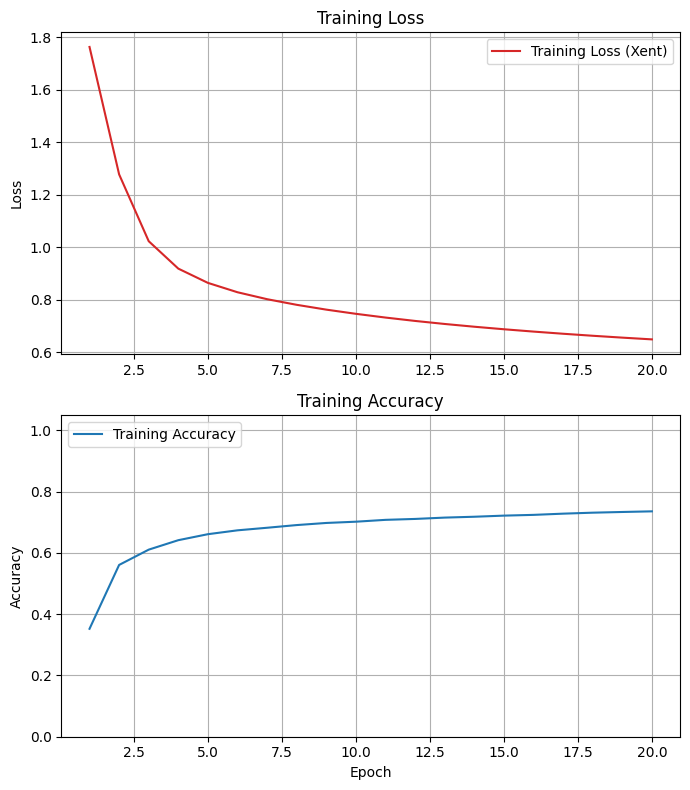

Final Training Loss:     0.6490
Final Training Accuracy: 0.7357
a1a = 0.7357


In [77]:
# Your code here

model = Sequential([
    Input(shape=(54,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    verbose=1
)

plot_history(history)

a1a = history.history['accuracy'][-1]
print(f"a1a = {a1a:.4f}")



In [96]:
# Set a1a to the final training accuracy at epoch 20

a1a = 0.7357             # Replace 0.0 with your answer

In [97]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a:.4f}')

a1a = 0.7357


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


--- Training with batch_size=4 ---


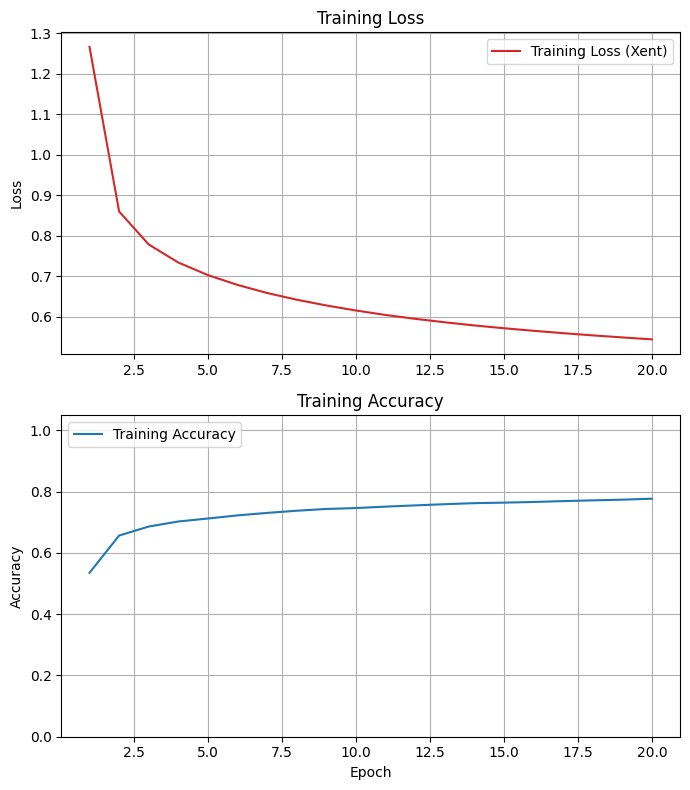

Final Training Loss:     0.5438
Final Training Accuracy: 0.7770
Batch size 4 - Final training accuracy: 0.7770

--- Training with batch_size=8 ---


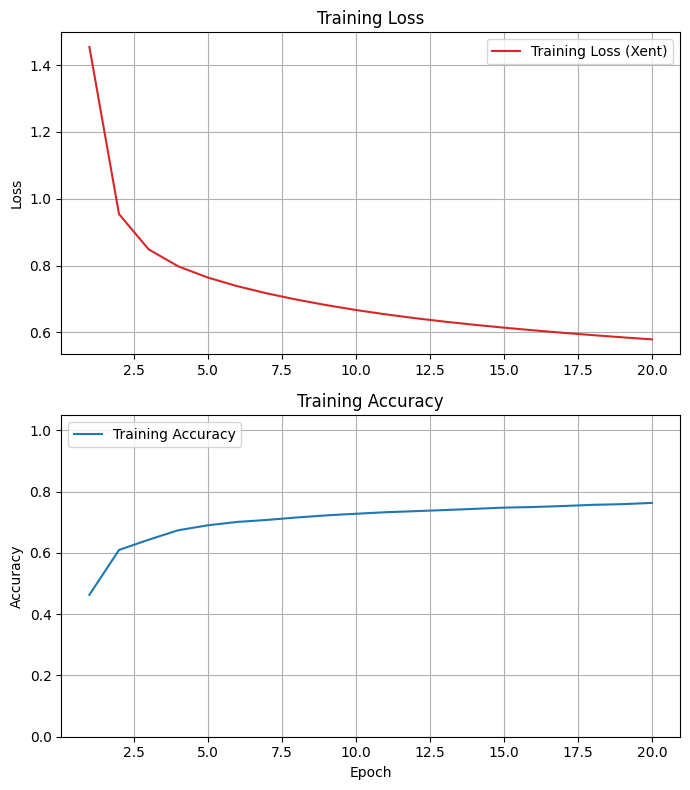

Final Training Loss:     0.5789
Final Training Accuracy: 0.7632
Batch size 8 - Final training accuracy: 0.7632

--- Training with batch_size=16 ---


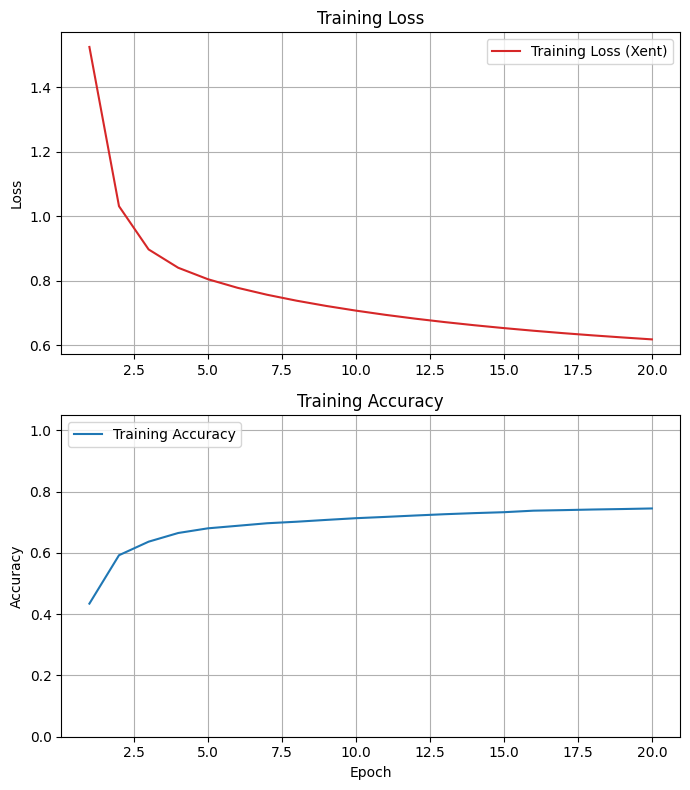

Final Training Loss:     0.6189
Final Training Accuracy: 0.7451
Batch size 16 - Final training accuracy: 0.7451

--- Training with batch_size=128 ---


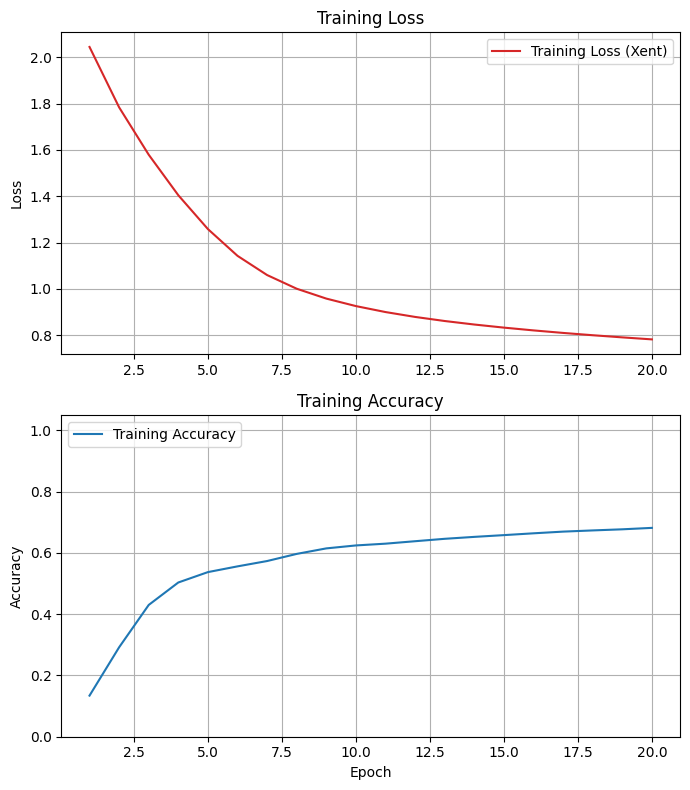

Final Training Loss:     0.7814
Final Training Accuracy: 0.6817
Batch size 128 - Final training accuracy: 0.6817

Best batch size: 4 (accuracy=0.7770)


In [80]:
# Your code here

batch_sizes = [4, 8, 16, 128]
results = {}

for batch_size in batch_sizes:
    print(f"\n--- Training with batch_size={batch_size} ---")

    model = Sequential([
        Input(shape=(54,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=20,
        verbose=0
    )

    plot_history(history)

    final_acc = history.history['accuracy'][-1]
    results[batch_size] = final_acc
    print(f"Batch size {batch_size} - Final training accuracy: {final_acc:.4f}")

best_batch = max(results, key=results.get)
a2a = best_batch
print(f"\nBest batch size: {a2a} (accuracy={results[a2a]:.4f})")


In [98]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = 4             # Replace 0 with your answer

In [99]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a}')

a2a = 4


In [100]:
# Set a2b to the best accuracy score found

a2b = 0.7770            # Replace 0.0 with your answer

In [101]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.7770


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



--- Training with learning_rate=0.001 ---


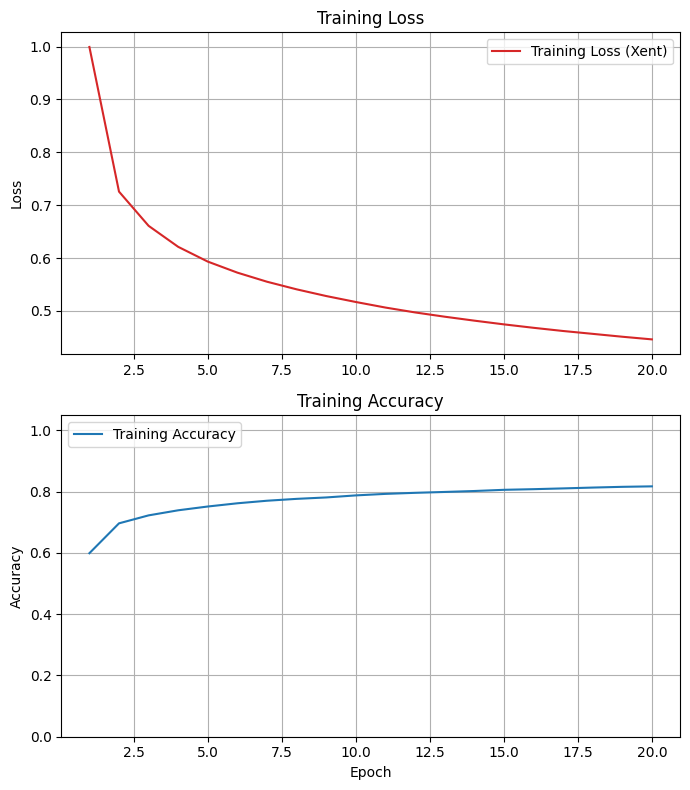

Final Training Loss:     0.4461
Final Training Accuracy: 0.8173
Learning rate 0.001 - Final training accuracy: 0.8173

--- Training with learning_rate=0.0005 ---


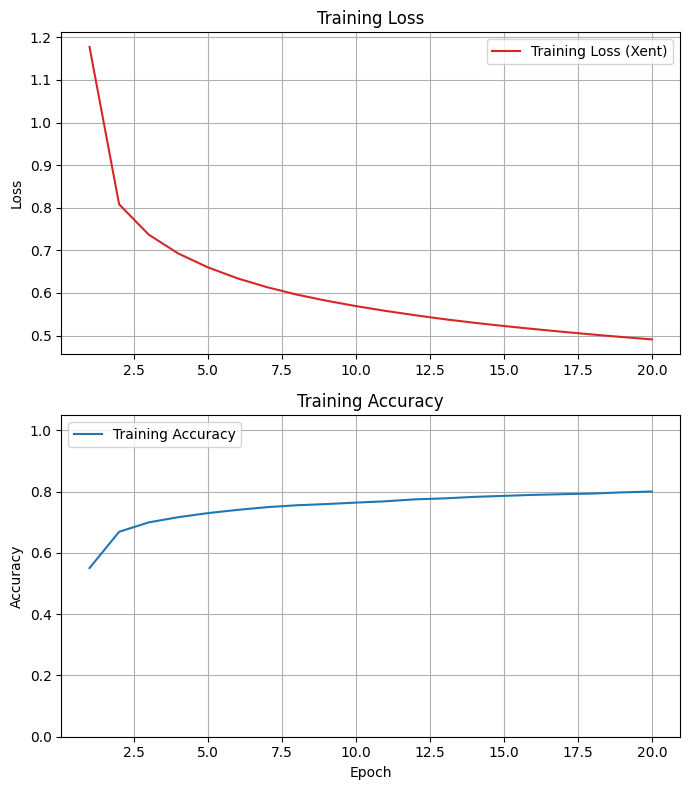

Final Training Loss:     0.4911
Final Training Accuracy: 0.8004
Learning rate 0.0005 - Final training accuracy: 0.8004

--- Training with learning_rate=0.0001 ---


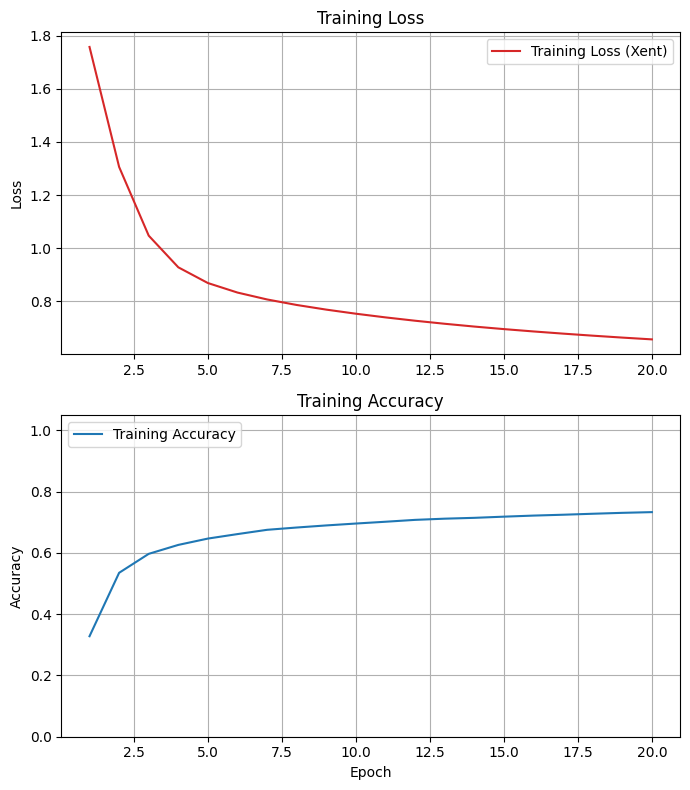

Final Training Loss:     0.6568
Final Training Accuracy: 0.7331
Learning rate 0.0001 - Final training accuracy: 0.7331

--- Training with learning_rate=5e-05 ---


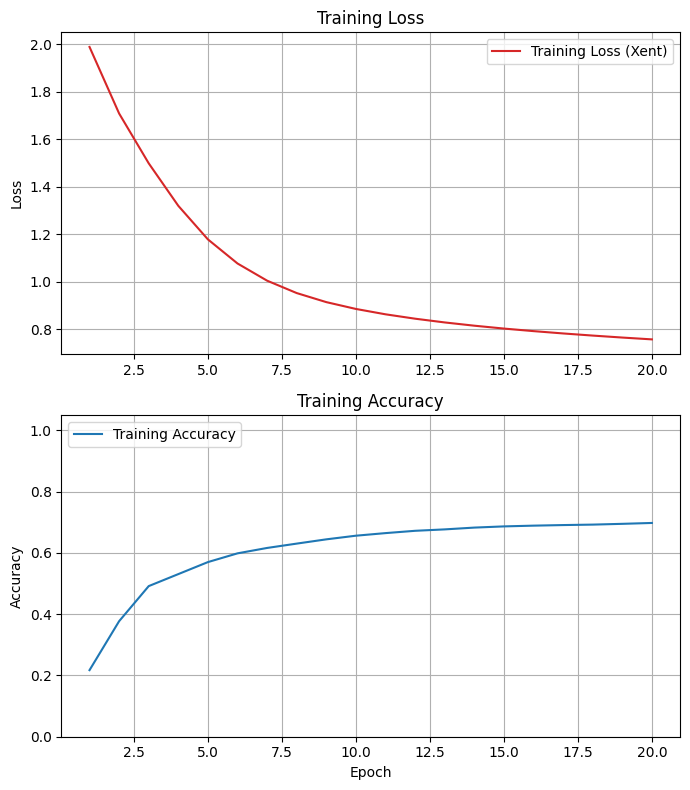

Final Training Loss:     0.7568
Final Training Accuracy: 0.6978
Learning rate 5e-05 - Final training accuracy: 0.6978

--- Training with learning_rate=1e-05 ---


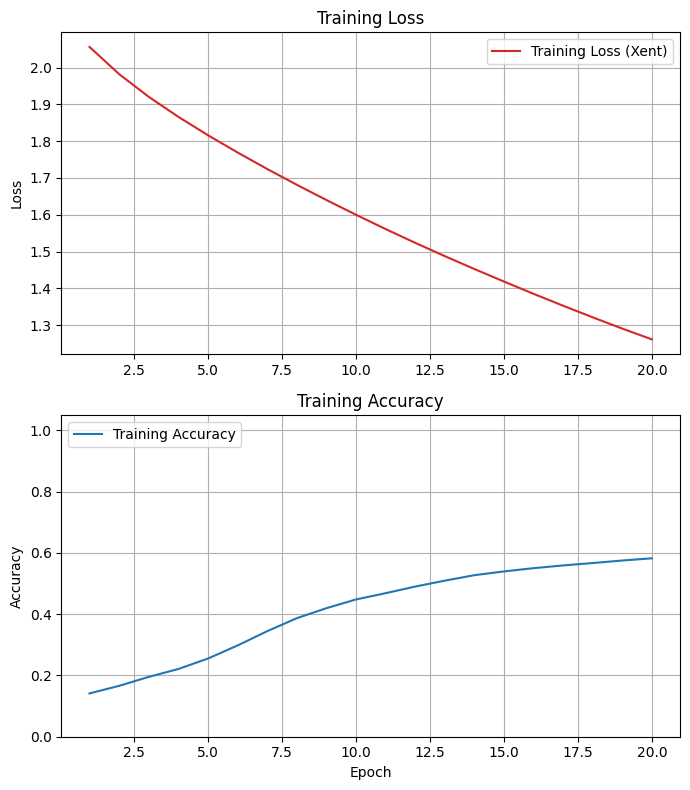

Final Training Loss:     1.2613
Final Training Accuracy: 0.5824
Learning rate 1e-05 - Final training accuracy: 0.5824

Best learning rate: 0.001 (accuracy=0.8173)


In [85]:
# Your code here
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
results = {}

for lr in learning_rates:
    print(f"\n--- Training with learning_rate={lr} ---")

    model = Sequential([
        Input(shape=(54,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=20,
        verbose=0
    )

    plot_history(history)

    final_acc = history.history['accuracy'][-1]
    results[lr] = final_acc
    print(f"Learning rate {lr} - Final training accuracy: {final_acc:.4f}")

best_lr = max(results, key=results.get)
a3a = best_lr
a3b = results[best_lr]

print(f"\nBest learning rate: {a3a} (accuracy={a3b:.4f})")


In [102]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = 0.001             # Replace 0.0 with your answer

In [103]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a:.4f}')

a3a = 0.0010


In [104]:
# Set a3b to the accuracy found by the best learning rate

a3b = 0.8173            # Replace 0.0 with your answer

In [105]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.8173


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam.

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


--- Training with initial_learning_rate=0.01 (Cosine Decay) ---


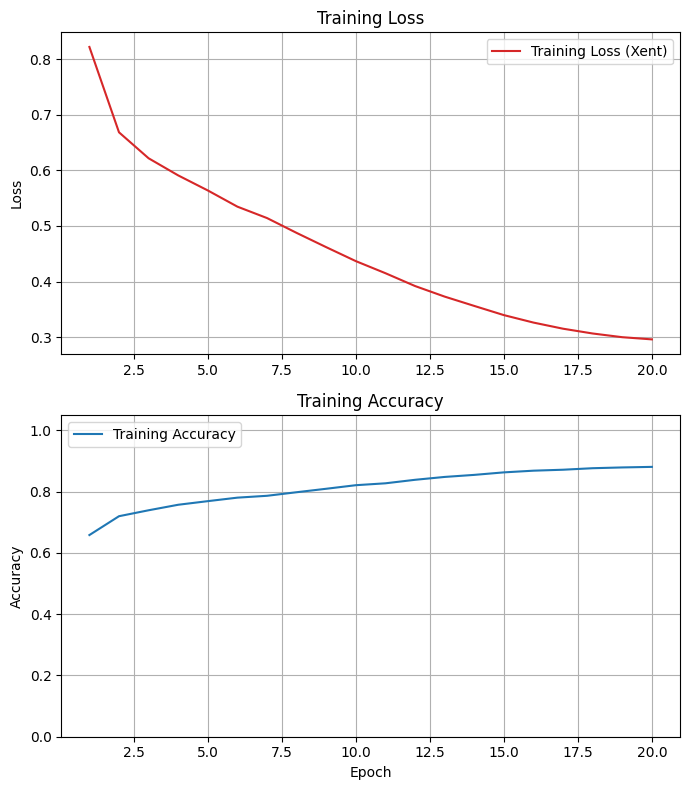

Final Training Loss:     0.2961
Final Training Accuracy: 0.8808
Initial LR 0.01 - Final training accuracy: 0.8808

--- Training with initial_learning_rate=0.005 (Cosine Decay) ---


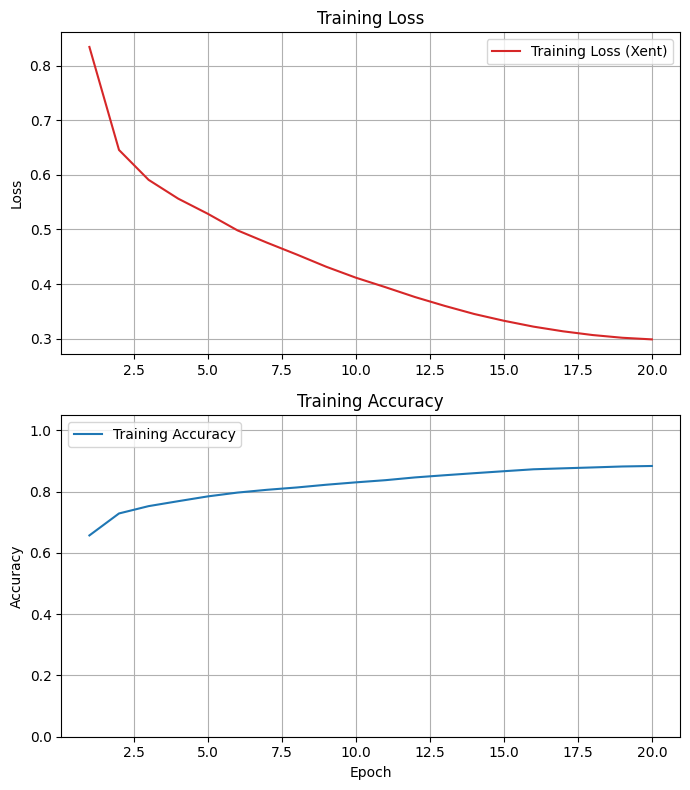

Final Training Loss:     0.2989
Final Training Accuracy: 0.8838
Initial LR 0.005 - Final training accuracy: 0.8838

--- Training with initial_learning_rate=0.001 (Cosine Decay) ---


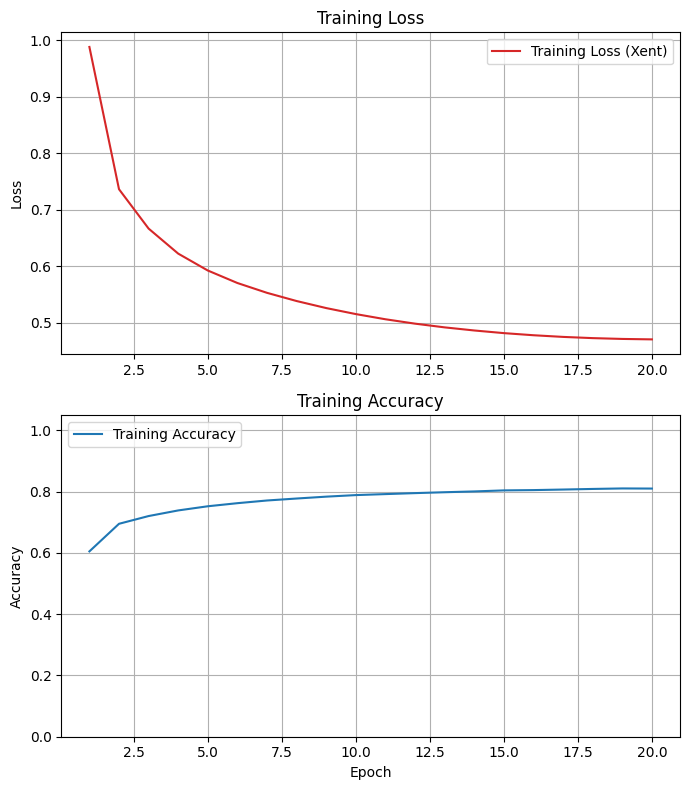

Final Training Loss:     0.4709
Final Training Accuracy: 0.8101
Initial LR 0.001 - Final training accuracy: 0.8101

--- Training with initial_learning_rate=0.0005 (Cosine Decay) ---


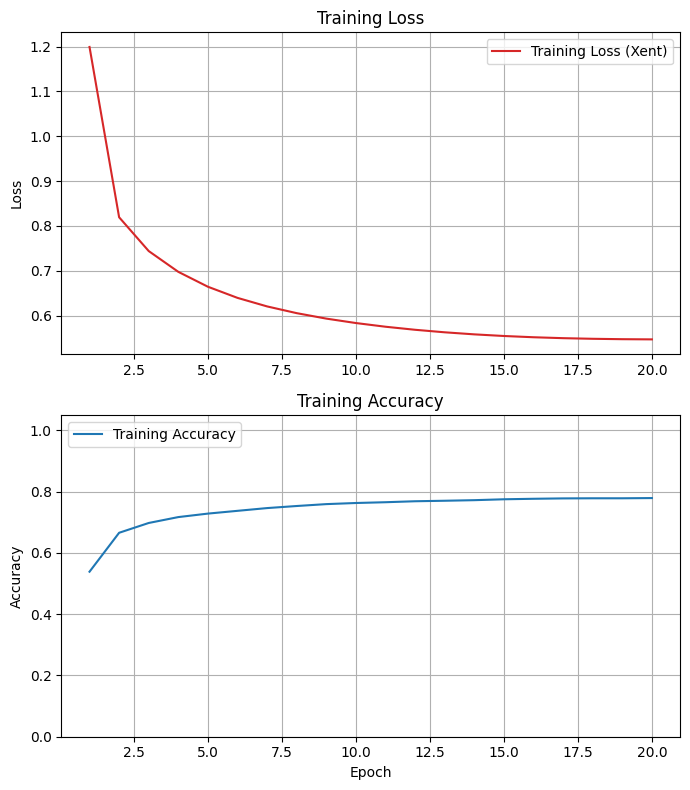

Final Training Loss:     0.5470
Final Training Accuracy: 0.7790
Initial LR 0.0005 - Final training accuracy: 0.7790

--- Training with initial_learning_rate=0.0001 (Cosine Decay) ---


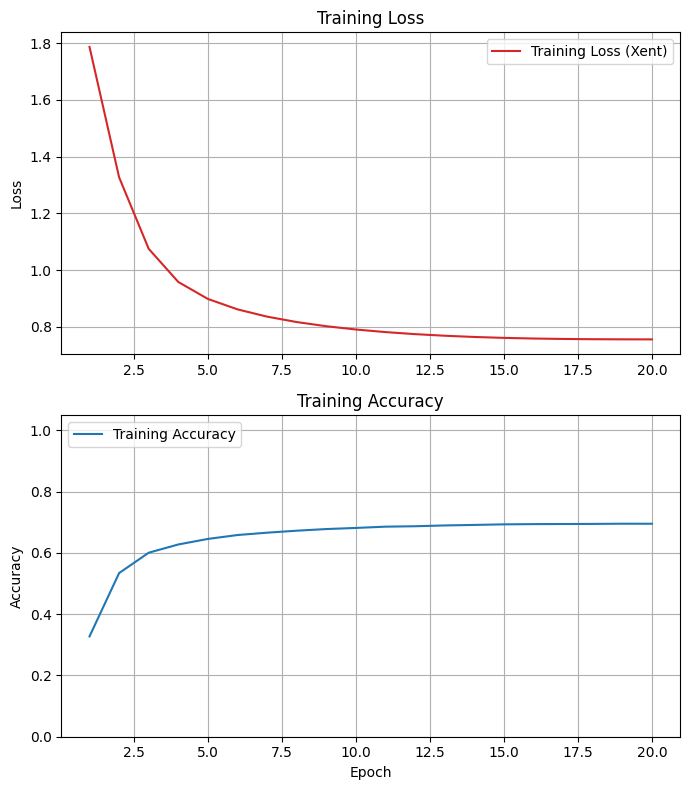

Final Training Loss:     0.7563
Final Training Accuracy: 0.6952
Initial LR 0.0001 - Final training accuracy: 0.6952

Best initial learning rate: 0.005 (accuracy=0.8838)


In [90]:
# Your code here
initial_learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
results = {}

steps_per_epoch = len(X_train) // 32
decay_steps = steps_per_epoch * 20

for initial_lr in initial_learning_rates:
    print(f"\n--- Training with initial_learning_rate={initial_lr} (Cosine Decay) ---")

    model = Sequential([
        Input(shape=(54,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    cosine_schedule = CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=decay_steps
    )

    model.compile(
        optimizer=Adam(learning_rate=cosine_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=20,
        verbose=0
    )

    plot_history(history)

    final_acc = history.history['accuracy'][-1]
    results[initial_lr] = final_acc
    print(f"Initial LR {initial_lr} - Final training accuracy: {final_acc:.4f}")

best_initial_lr = max(results, key=results.get)
a4a = best_initial_lr
a4b = results[best_initial_lr]

print(f"\nBest initial learning rate: {a4a} (accuracy={a4b:.4f})")


In [106]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = 0.005            # Replace 0.0 with your answer

In [107]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a:.4f}')

a4a = 0.0050


In [108]:
# Set a4b to the best accuracy found

a4b = 0.8838            # Replace 0.0 with your answer

In [109]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.8838


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture.

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

Training final best model with selected hyperparameters...
Using Cosine Decay with initial_lr=0.005, batch_size=4
Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6172 - loss: 0.9495
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7120 - loss: 0.7023
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7326 - loss: 0.6423
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7543 - loss: 0.6044
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7613 - loss: 0.5722
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7747 - loss: 0.5517
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7773 - loss: 0.5419
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7852 - loss: 0.5148
Epoch 9/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7980 - loss: 0.4921
Epoch 10/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8055 - loss: 0.4752
Epoc

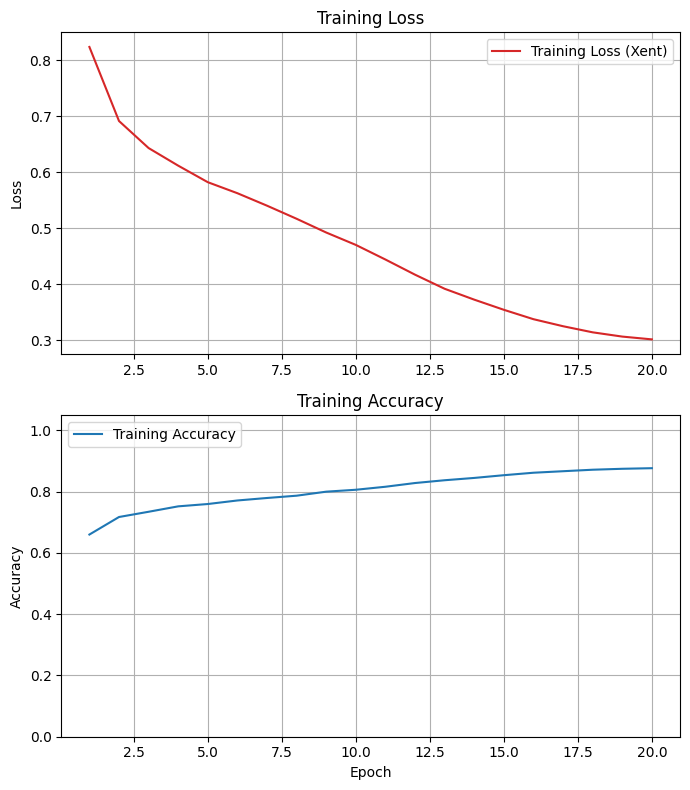

Final Training Loss:     0.3019
Final Training Accuracy: 0.8766
Best training accuracy: 0.8766
Test accuracy: 0.8305

Final Results:
a5a (best training accuracy): 0.8766
a5b (test accuracy): 0.8305


In [110]:
# Your code here -- add as many cells as you need

best_batch_size = 4
use_cosine_decay = True
best_initial_lr = 0.005

print("Training final best model with selected hyperparameters...")

best_model = Sequential([
    Input(shape=(54,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

steps_per_epoch = len(X_train) // best_batch_size
decay_steps = steps_per_epoch * 20
schedule = CosineDecay(
    initial_learning_rate=best_initial_lr,
    decay_steps=decay_steps
)
optimizer = Adam(learning_rate=schedule)
print(f"Using Cosine Decay with initial_lr={best_initial_lr}, batch_size={best_batch_size}")

best_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

best_history = best_model.fit(
    X_train, y_train,
    batch_size=best_batch_size,
    epochs=20,
    verbose=1
)

plot_history(best_history)

a5a = best_history.history['accuracy'][-1]
print(f"Best training accuracy: {a5a:.4f}")

test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
a5b = test_accuracy
print(f"Test accuracy: {a5b:.4f}")

print(f"\nFinal Results:")
print(f"a5a (best training accuracy): {a5a:.4f}")
print(f"a5b (test accuracy): {a5b:.4f}")

In [111]:
# Set a5a to the best training accuracy found by your best model

a5a = 0.8766             # Replace 0.0 with your answer

In [112]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5a = {a5a:.4f}')

a5a = 0.8766


In [113]:
# Set a5b to the test accuracy found by your best model

a5b = 0.8305             # Replace 0.0 with your answer

In [114]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5b = {a5b:.4f}')

a5b = 0.8305


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc?

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


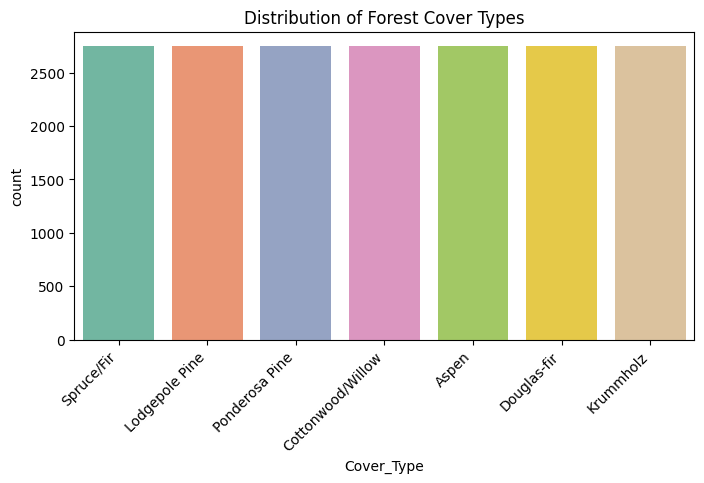

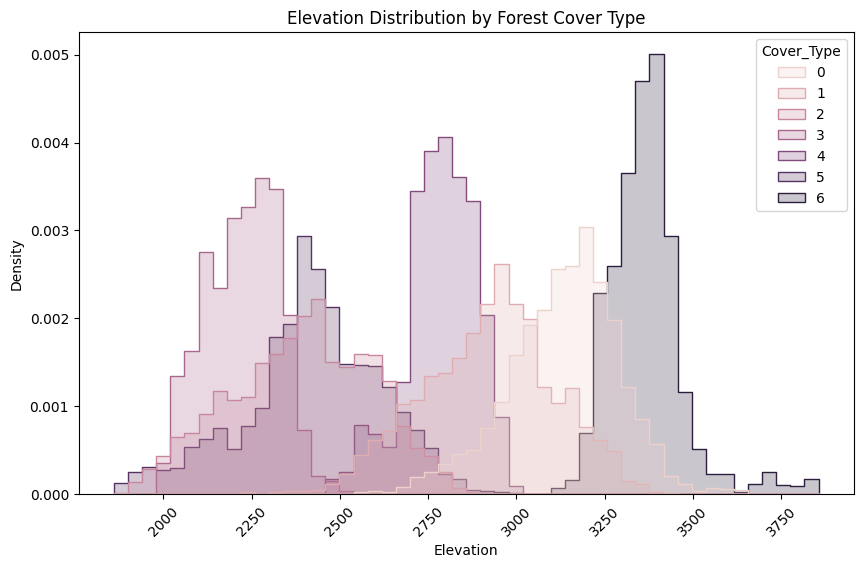

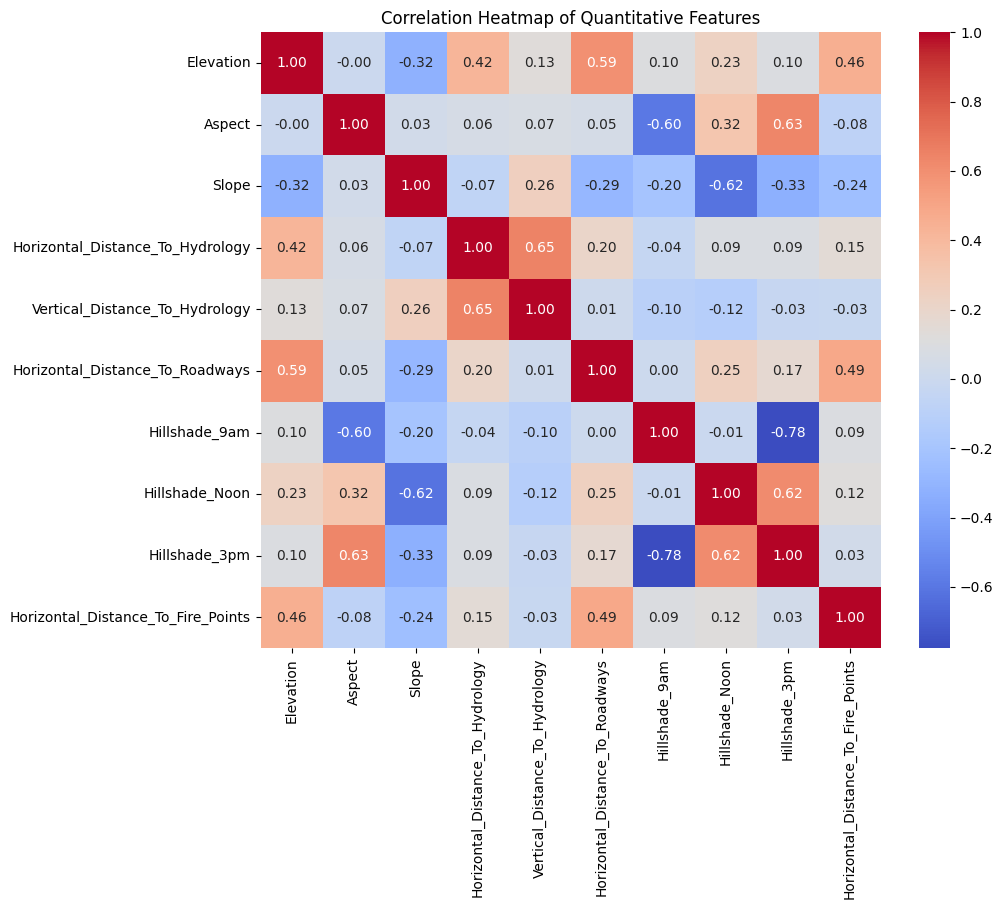

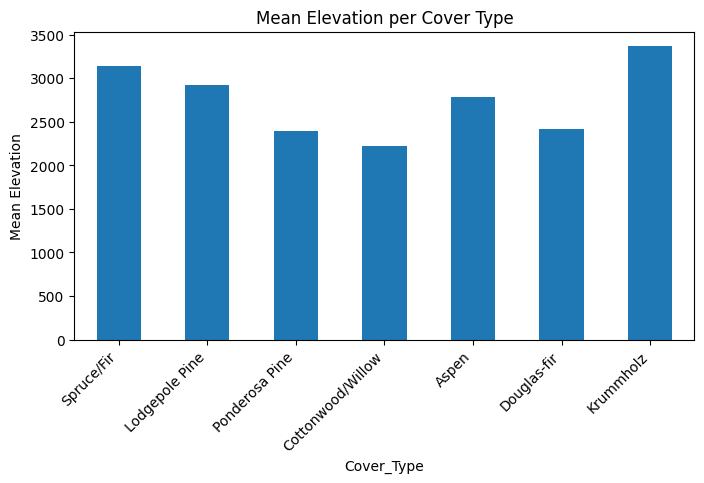

In [115]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
